# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv(
    "data/bank-additional-full.csv",
    sep=";",
)

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [5]:
for column in [
    "y",
    "loan",
    "housing",
    "month",
    "job",
    "marital",
    "education",
    "default",
    "poutcome",
    "contact",
]:
    print(df[column].value_counts())
    print("\n")
    print(df[column].value_counts(normalize=True).round(2))
    print("\n")

y
no     36548
yes     4640
Name: count, dtype: int64


y
no     0.89
yes    0.11
Name: proportion, dtype: float64


loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64


loan
no         0.82
yes        0.15
unknown    0.02
Name: proportion, dtype: float64


housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64


housing
yes        0.52
no         0.45
unknown    0.02
Name: proportion, dtype: float64


month
may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: count, dtype: int64


month
may    0.33
jul    0.17
aug    0.15
jun    0.13
nov    0.10
apr    0.06
oct    0.02
sep    0.01
mar    0.01
dec    0.00
Name: proportion, dtype: float64


job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         10

In [6]:
for column in [
    "loan",
    "housing",
    "job",
    "marital",
    "education",
    "default",
]:
    print(column)
    print(df[column].value_counts()["unknown"])
    print(df[column].value_counts(normalize=True).round(2)["unknown"])
    print("\n")

loan
990
0.02


housing
990
0.02


job
330
0.01


marital
80
0.0


education
1731
0.04


default
8597
0.21




### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [7]:
df.shape

(41188, 21)

In [8]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [9]:
df.describe(include="object")

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [10]:
df.duplicated().sum()

12

#### Key observations
* Roughly equal number of numeric and categorical columns
* no null values in the dataset
* default can be dropped because of high skewness of the data - only 3 rows having 'yes'
* duration should be discarded as explained above in the input variables section

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Business objective
The main goal of this task is to improve the bank's marketing efforts by predicting whether a customer will subscribe to a term deposit based on their characteristics and past interactions. This will allow the bank to:
* Increase efficiency: By targeting marketing calls more effectively, the bank's resources will be used more efficiently.
* Improve ROI (return on investment): With the same number of calls, the bank can generate more successful subscriptions.
* Enhance customer experience: Better targeting means calling customers who are interested, which can lead to increased customer satisfaction.


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [12]:
# dropping duration column as adived above.
# dropping default since it's extremely imbalanced with only 3 data points have a value of yes
df = df.drop(["duration", "default"], axis=1)
df.shape

(41188, 19)

In [13]:
# remove duplicates
df = df.drop_duplicates()
df.shape

(39191, 19)

##### Exploratory Data Analysis

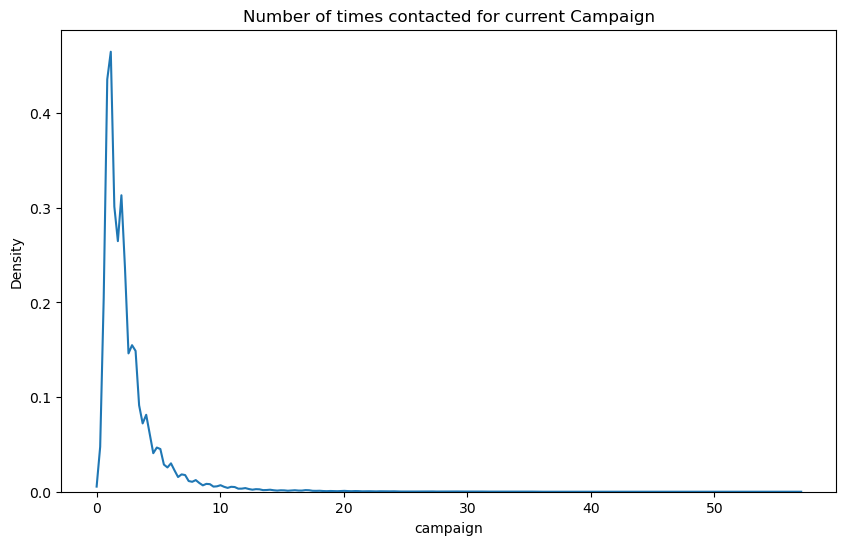

In [14]:
# count plot of campaign
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="campaign")
plt.title("Number of times contacted for current Campaign")
plt.show()

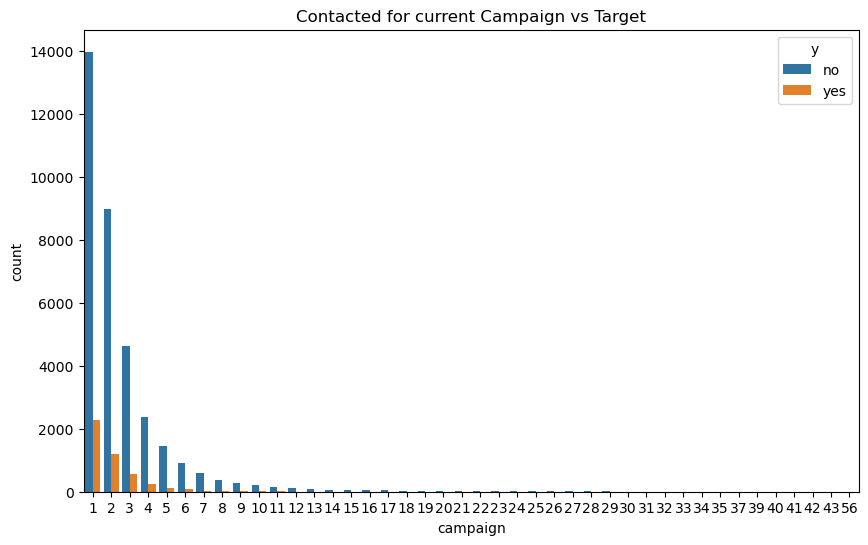

In [15]:
# plot campagin column vs target variable
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="campaign", hue="y")
plt.title("Contacted for current Campaign vs Target")
plt.show()

Text(0, 0.5, 'Subscription Count')

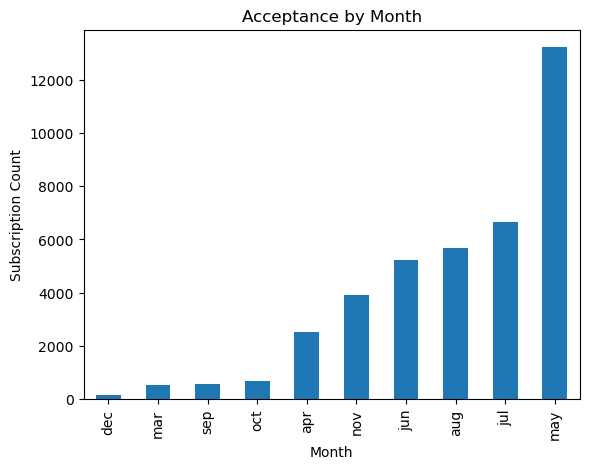

In [16]:
ax = (
    df.groupby("month")["y"]
    .count()
    .sort_values()
    .plot(kind="bar", title="Acceptance by Month")
)
ax.set_xlabel("Month")
ax.set_ylabel("Subscription Count")

Highest conversion rate for university degree, high school and basic 9y


Text(24.0, 0.5, 'Subscription Count')

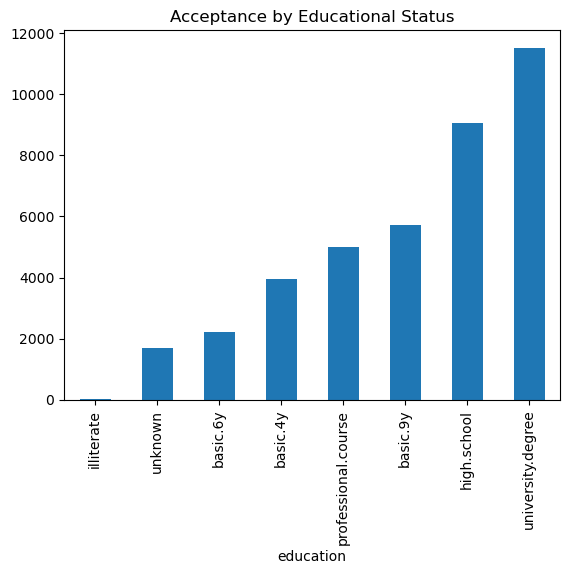

In [17]:
df.groupby("education")["y"].count().sort_values().plot(
    kind="bar", title="Acceptance by Educational Status"
)
print("Highest conversion rate for university degree, high school and basic 9y")
ax.set_ylabel("Subscription Count")

Text(0, 0.5, 'Subscription Count')

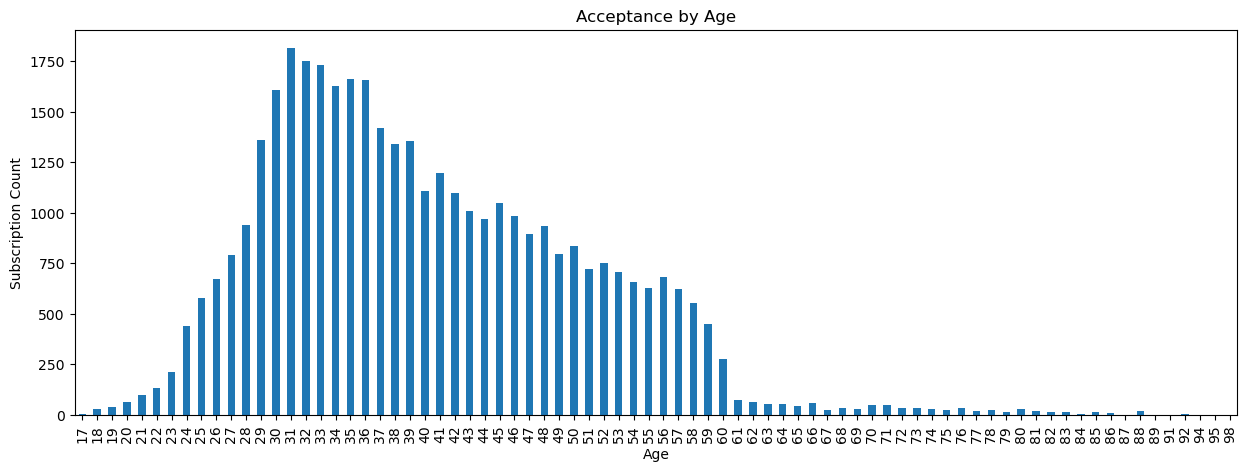

In [18]:
ax = (
    df.groupby("age")["y"]
    .count()
    .plot(kind="bar", title="Acceptance by Age", figsize=(15, 5))
)
ax.set_xlabel("Age")
ax.set_ylabel("Subscription Count")

Text(0, 0.5, 'Subscription Count')

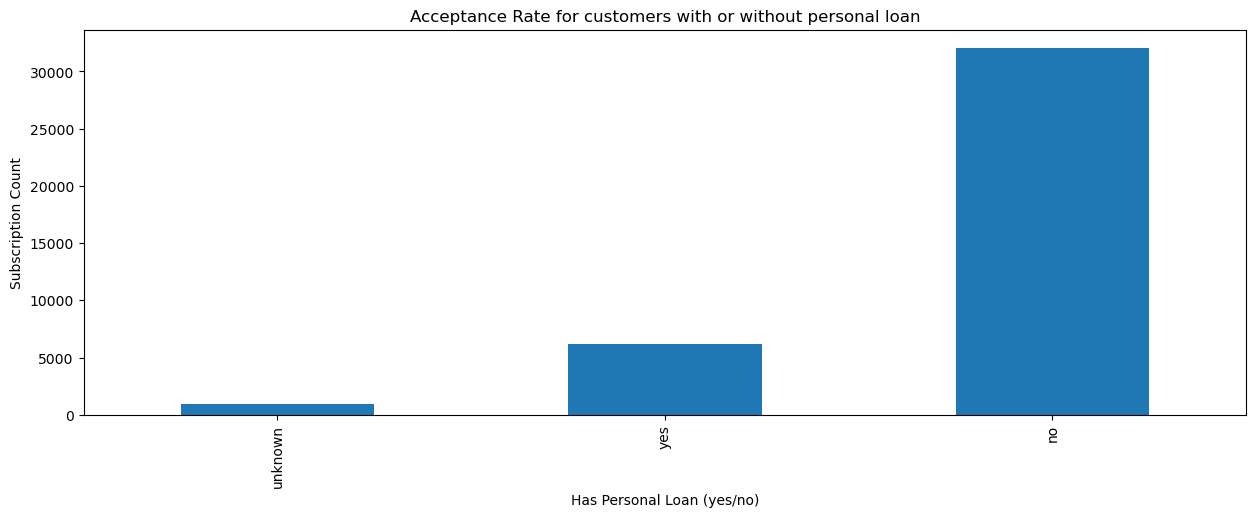

In [19]:
ax = (
    df.groupby("loan")["y"]
    .count()
    .sort_values()
    .plot(
        kind="bar",
        figsize=(15, 5),
        title="Acceptance Rate for customers with or without personal loan",
    )
)
ax.set_xlabel("Has Personal Loan (yes/no)")
ax.set_ylabel("Subscription Count")

Text(24.000000000000014, 0.5, 'Subscription Count')

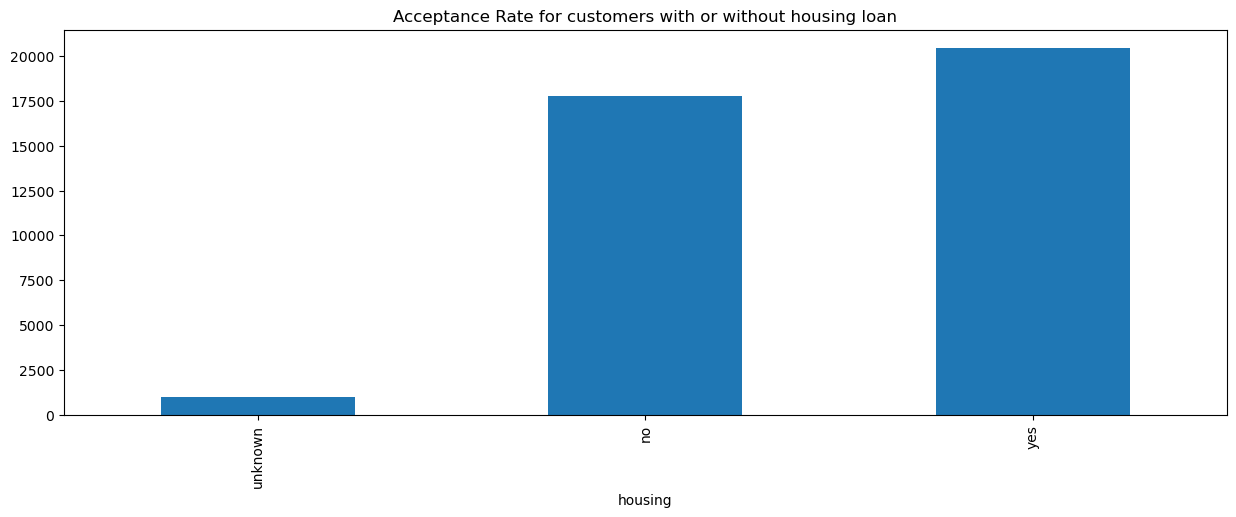

In [20]:
df.groupby("housing")["y"].count().sort_values().plot(
    kind="bar",
    figsize=(15, 5),
    title="Acceptance Rate for customers with or without housing loan",
)
ax.set_xlabel("Has Housing Loan (yes/no)")
ax.set_ylabel("Subscription Count")

Categorical Variables Visualization 



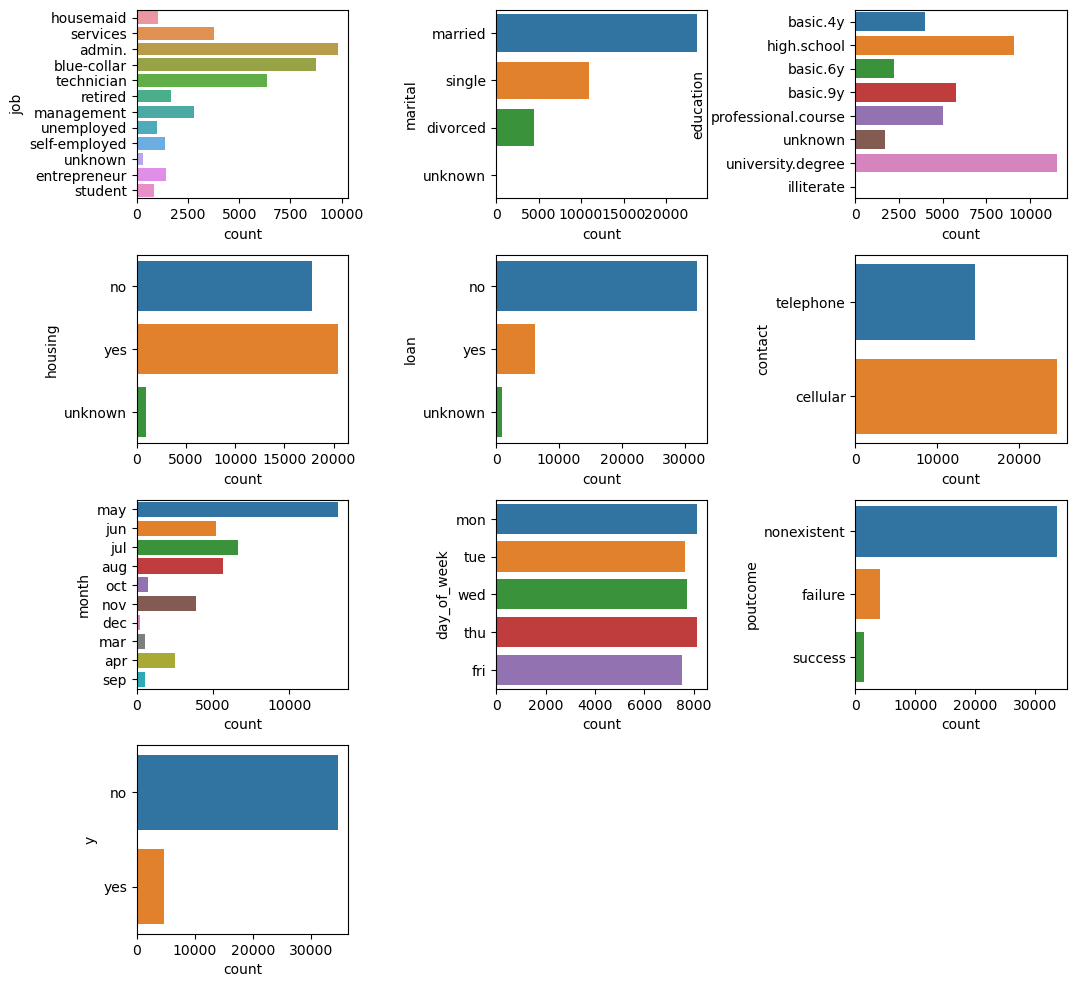

In [21]:
print("Categorical Variables Visualization", "\n")
categorical_columns = df.describe(include=[object]).columns
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.3
)
for i, ax in enumerate(axes.ravel()):
    if i > 9:
        ax.set_visible(False)
        continue
    sns.countplot(y=categorical_columns[i], data=df, ax=ax)
plt.show()

##### Key points
* Age above 60 years aren't accepted as much as below 60 years
* Married individuals are more likely to be accepted
* Having a housing loan increases the chances of getting accepted. While having a personal loan decreases the chances

In [22]:
# convert target column to numeric
df["y"] = df["y"].map({"no": 0, "yes": 1})

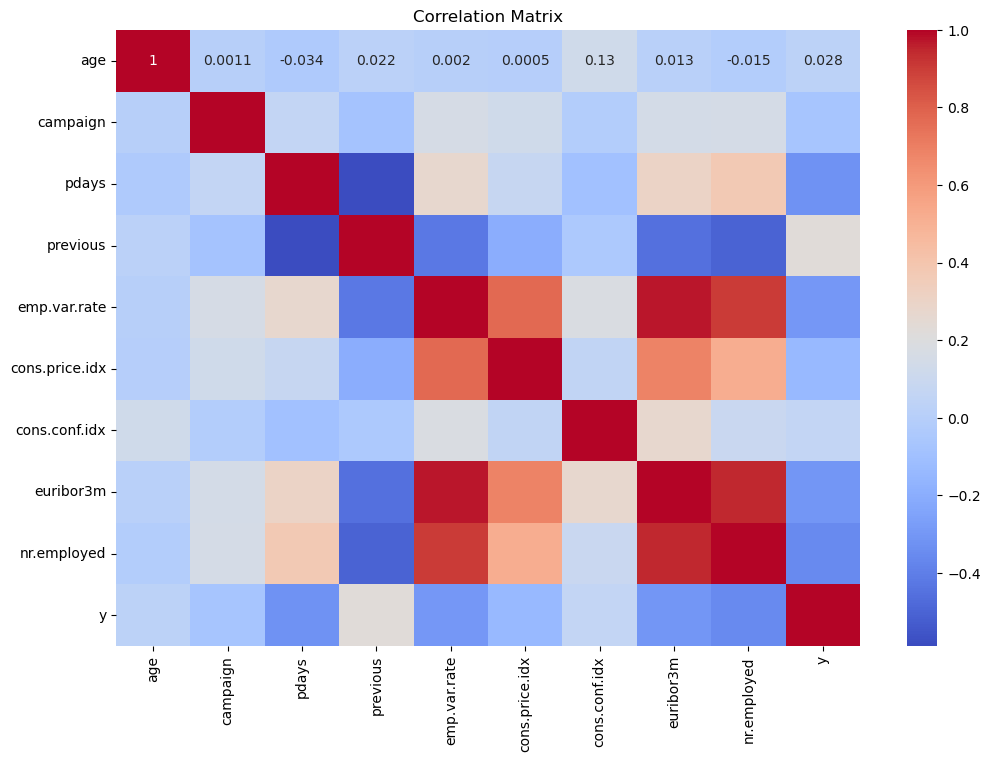

In [23]:
# Compute the correlation matrix for numeric features
numeric_df = df.select_dtypes(include=[float, int])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [24]:
X = df.drop("y", axis=1)
y = df["y"]

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [25]:
# Separating the features and the target variable
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (31352, 18)
y_train:  (31352,)
X_test:  (7839, 18)
y_test:  (7839,)


In [26]:
categorical_columns = X.select_dtypes(include=["object"]).columns
numeric_columns = X.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_columns),
        ("cat", OneHotEncoder(), categorical_columns),
    ],
    remainder="passthrough",
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)  # to avoid data leakage

In [27]:
# Get the names of the one-hot encoded columns
onehot_encoded_columns = preprocessor.named_transformers_["cat"].get_feature_names_out(
    categorical_columns
)

# Combine the numerical and one-hot encoded column names
all_feature_names = np.concatenate([numeric_columns, onehot_encoded_columns])

# Convert to a list for easy handling
all_feature_names = list(all_feature_names)

# Create DataFrames with the processed data and feature names
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)
print("X_train_processed_df shape:", X_train_processed_df.shape)
print("X_test_processed_df shape:", X_test_processed_df.shape)
print("Columns of X_train_processed_df:", X_train_processed_df.columns)
print("Columns of X_test_processed_df:", X_test_processed_df.columns)

X_train_processed_df shape: (31352, 59)
X_test_processed_df shape: (7839, 59)
Columns of X_train_processed_df: Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'housing_no', 'housing_unknown', 'housing_yes',
       'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'mon

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [28]:
# Building a dummy model
dummy = DummyClassifier(strategy="most_frequent").fit(X_train_processed_df, y_train)
y_pred_test = dummy.predict(X_test_processed_df)
y_pred_train = dummy.predict(X_train_processed_df)
baseline_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Baseline Test Accuracy: {baseline_accuracy: .2f}")

target_names = ["not subscribed", "subscribed"]
report = classification_report(y_test, y_pred_test, target_names=target_names)
print(report)

Baseline Test Accuracy:  0.88
                precision    recall  f1-score   support

not subscribed       0.88      1.00      0.94      6920
    subscribed       0.00      0.00      0.00       919

      accuracy                           0.88      7839
     macro avg       0.44      0.50      0.47      7839
  weighted avg       0.78      0.88      0.83      7839



In [29]:
y_train.value_counts(normalize=True)

y
0    0.882687
1    0.117313
Name: proportion, dtype: float64

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [30]:
logreg = LogisticRegression().fit(X_train_processed_df, y_train)

### Problem 9: Score the Model

What is the accuracy of your model?

In [31]:
# Evaluate the model
logreg_train_accuracy = logreg.score(X_train_processed_df, y_train)
logreg_test_accuracy = logreg.score(X_test_processed_df, y_test)
y_preds_test_log = logreg.predict(X_test_processed_df)
y_preds_train_log = logreg.predict(X_train_processed_df)
print(f"Logistic Regression train accuracy: {logreg_train_accuracy: .2f}")
print(f"Logistic Regression test accuracy: {logreg_test_accuracy: .2f}")
precision_test = precision_score(y_test, y_preds_test_log)
precision_train = precision_score(y_train, y_preds_train_log)
recall = recall_score(y_test, y_preds_test_log)
print(
    f"Precision Test score: {precision_test: .2f}\nPrecision train score: {precision_train: .2f}\nRecall: {recall: .2f}"
)

Logistic Regression train accuracy:  0.90
Logistic Regression test accuracy:  0.90
Precision Test score:  0.72
Precision train score:  0.66
Recall:  0.25


In [32]:
report = classification_report(y_test, y_preds_test_log, target_names=target_names)
print(report)

                precision    recall  f1-score   support

not subscribed       0.91      0.99      0.95      6920
    subscribed       0.72      0.25      0.37       919

      accuracy                           0.90      7839
     macro avg       0.82      0.62      0.66      7839
  weighted avg       0.89      0.90      0.88      7839



### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [33]:
# Build and score models with default settings
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(random_state=42),
}
results = []

In [34]:
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_processed_df, y_train)
    train_time = time.time() - start_time
    train_acc = model.score(X_train_processed_df, y_train)
    test_acc = model.score(X_test_processed_df, y_test)
    y_pred_train = model.predict(X_train_processed_df)
    y_pred_test = model.predict(X_test_processed_df)
    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)
    results.append(
        [name, train_time, train_acc, test_acc, precision_train, precision_test]
    )

In [35]:
results_df = pd.DataFrame(
    results,
    columns=[
        "Model",
        "Train Time (s)",
        "Train Accuracy",
        "Test Accuracy",
        "Train Precision",
        "Test Precision",
    ],
)
display(results_df)

,Model,Train Time (s),Train Accuracy,Test Accuracy,Train Precision,Test Precision
0,Logistic Regression,0.279840,0.895318,0.900880,0.660714,0.724684
1,KNN,0.001643,0.908427,0.888123,0.700447,0.542339
2,Decision Tree,0.174868,0.994546,0.832377,1.000000,0.305419
3,SVM,48.276918,0.900612,0.898584,0.696779,0.667568


<Figure size 1000x600 with 0 Axes>

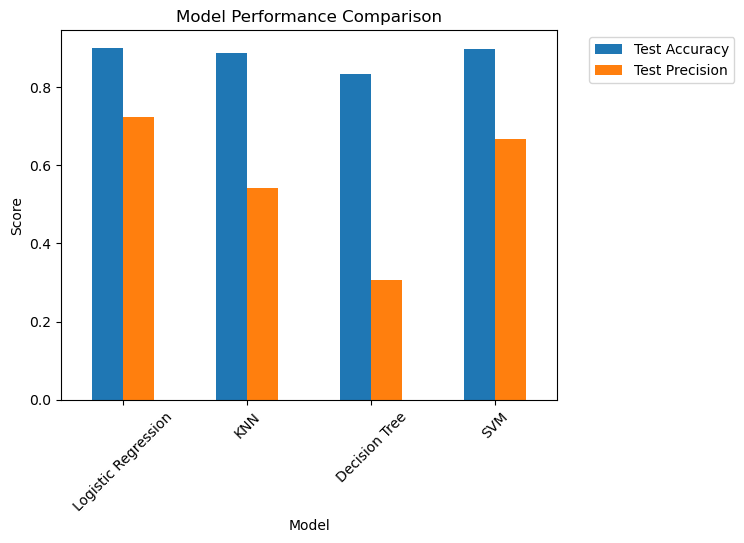

In [36]:
plt.figure(figsize=(10, 6))
results_df.set_index("Model")[["Test Accuracy", "Test Precision"]].plot(kind="bar")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.show()

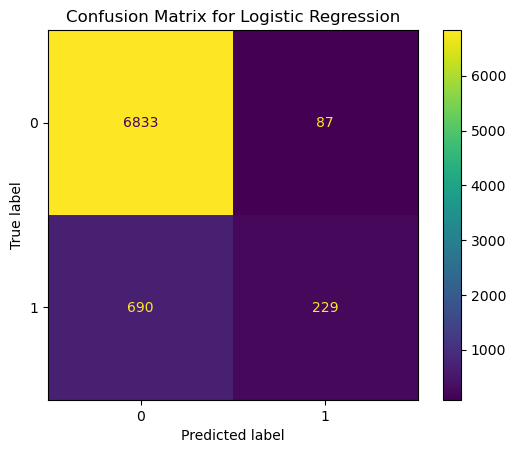

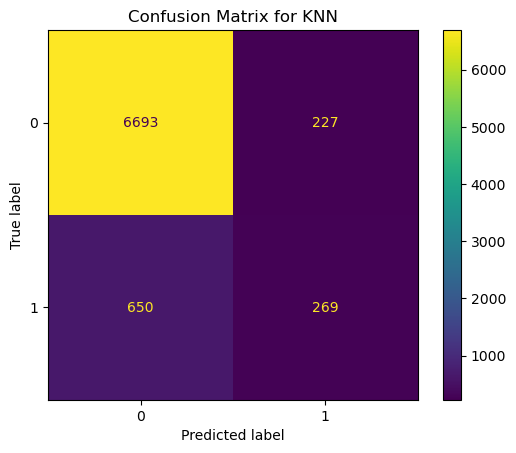

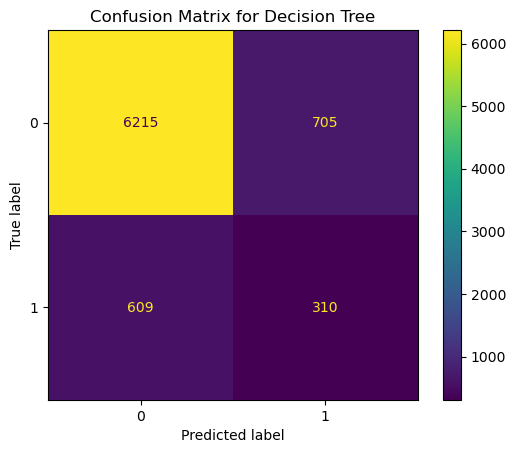

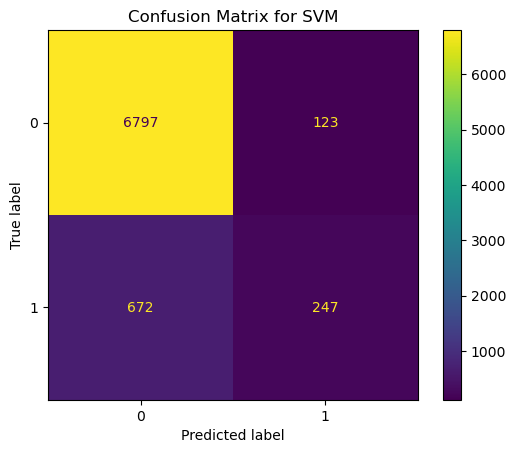

In [37]:
# Plot confusion matrix for each model
for name, model in models.items():
    y_pred_test = model.predict(X_test_processed_df)
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [38]:
# since SVM is computationally expensive, we will perform the grid search
# on a smaller subset of our dataset provided in bank-additional.csv
# after we have gathered the best hyperparameter values, we will train the model on the full dataset
df_small = pd.read_csv(
    "data/bank-additional.csv",
    sep=";",
)
df_small = df_small.drop_duplicates()
df_small["y"] = df_small["y"].replace({"yes": 1, "no": 0})
df_small = df_small.drop(["duration", "default"], axis=1)

# Split into features and target
X_small = df_small.drop("y", axis=1)
y_small = df_small["y"]
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42, stratify=y_small
)
X_train_small_processed = preprocessor.fit_transform(X_train_small)
X_test_small_processed = preprocessor.transform(X_test_small)

In [39]:
print(X_train_small_processed.shape)
print(X_test_small_processed.shape)
print(y_train_small.shape)
print(y_test_small.shape)

(3295, 59)
(824, 59)
(3295,)
(824,)


In [40]:
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2", "None"],
    "solver": ["liblinear", "newton-cg", "lbfgs"],
}
param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "p": [1, 2],
}
param_grid_dt = {
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"],
}
param_grid_svm = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "poly", "sigmoid"],
    "gamma": ["scale", "auto"],
}
models_param_grids = {
    "Logistic Regression": (LogisticRegression(random_state=42), param_grid_lr),
    "KNN": (KNeighborsClassifier(), param_grid_knn),
    "Decision Tree": (DecisionTreeClassifier(random_state=42), param_grid_dt),
    "SVM": (SVC(random_state=42, probability=True), param_grid_svm),
}
grid_search_results = []

In [41]:
# Perform grid search for each model, optimizing for precision
# since we are dealing with an imbalanced dataset and want to find out who will subscribe
for name, (model, param_grid) in tqdm(
    models_param_grids.items(), desc="Model Grid Search", total=len(models_param_grids)
):
    print(f"Starting grid search for {name}")
    if name == "SVM":
        grid_search = GridSearchCV(
            model, param_grid, cv=5, scoring="precision", n_jobs=-1, verbose=3
        )
        grid_search.fit(X_train_small_processed, y_train_small)
    else:
        grid_search = GridSearchCV(
            model, param_grid, cv=5, scoring="precision", n_jobs=-1
        )
        grid_search.fit(X_train_processed_df, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    grid_search_results.append([name, best_params, best_score])
    print(f"Finished grid search for {name}")
    print(f"Best parameters for {name}: {best_params}")
    print(f"Best cross-validation score for {name}: {best_score}")

Model Grid Search:   0%|                                  | 0/4 [00:00<?, ?it/s]

Starting grid search for Logistic Regression


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Finished grid search for Logistic Regression
Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score for Logistic Regression: 0.6862264484581191
Starting grid search for KNN


Model Grid Search:  50%|█████████████             | 2/4 [01:11<01:18, 39.17s/it]

Finished grid search for KNN
Best parameters for KNN: {'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
Best cross-validation score for KNN: 0.57913911970383
Starting grid search for Decision Tree


/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt

/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt

/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt

/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt

/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt

/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt

Finished grid search for Decision Tree
Best parameters for Decision Tree: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation score for Decision Tree: 0.6098758856267874
Starting grid search for SVM
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.647 total time=   0.8s
[CV 1/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=1.000 total time=   0.8s
[CV 4/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.462 total time=   0.9s
[CV 1/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.625 total time=   0.7s
[CV 4/5] END ....C=0.1, gamma=auto, kernel=poly;, score=1.000 total time=   0.7s
[CV 2/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.000 total time=   0.9s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.677 total time=   4.7s
[CV 1/5] END ......C=1, gamma=auto, kernel=poly;, score=0.562 total time=   0.7s
[CV 2/5] END ......C=1, gamma=auto, kernel=poly;, score=0.650 total time=   0.7s
[CV 4/5] END ......C=1, gamma=auto, kernel=poly;, score=0.720 total time=   0.8s
[CV 1/5] END ...C=1, gamma=auto, kernel=sigmoid;, score=0.500 total time=   0.9s
[CV 4/5] END ...C=1, gamma=auto, kernel=sigmoid;, score=0.571 total time=   0.8s
[CV 2/5] END ..C=10, gamma=s

Model Grid Search: 100%|█████████████████████████| 4/4 [50:48<00:00, 762.07s/it]

Finished grid search for SVM
Best parameters for SVM: {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
Best cross-validation score for SVM: 0.7386904761904762


In [42]:
grid_search_results_df = pd.DataFrame(
    grid_search_results, columns=["Model", "Best Parameters", "Best CV Score"]
)

# Train final models with the best parameters and evaluate
final_results = []

for name, (model, param_grid) in tqdm(
    models_param_grids.items(),
    desc="Training Final Models",
    total=len(models_param_grids),
):
    best_params = grid_search_results_df.loc[
        grid_search_results_df["Model"] == name, "Best Parameters"
    ].values[0]
    model.set_params(**best_params)

    start_time = time.time()
    model.fit(X_train_processed_df, y_train)
    train_time = time.time() - start_time

    train_acc = model.score(X_train_processed_df, y_train)
    test_acc = model.score(X_test_processed_df, y_test)
    y_pred_train = model.predict(X_train_processed_df)
    y_pred_test = model.predict(X_test_processed_df)
    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)

    final_results.append(
        [
            name,
            best_params,
            train_time,
            train_acc,
            test_acc,
            precision_train,
            precision_test,
        ]
    )
    print(f"Finished training and evaluation for {name}")

Training Final Models:  25%|█████▌                | 1/4 [00:00<00:00,  4.99it/s]

Finished training and evaluation for Logistic Regression


Training Final Models:  50%|███████████           | 2/4 [00:04<00:04,  2.40s/it]

Finished training and evaluation for KNN
Finished training and evaluation for Decision Tree


Training Final Models: 100%|██████████████████████| 4/4 [01:35<00:00, 23.91s/it]

Finished training and evaluation for SVM


In [43]:
final_results_df = pd.DataFrame(
    final_results,
    columns=[
        "Model",
        "Best Parameters",
        "Train Time",
        "Train Accuracy",
        "Test Accuracy",
        "Train Precision",
        "Test Precision",
    ],
)
print("Final Model Results\n")
final_results_df

Final Model Results



,Model,Best Parameters,Train Time,Train Accuracy,Test Accuracy,Train Precision,Test Precision
0,Logistic Regression,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.139856,0.894807,0.898839,0.687377,0.742308
1,KNN,"{'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}",0.004321,0.900325,0.893864,0.666266,0.604317
2,Decision Tree,"{'max_depth': 10, 'max_features': 'log2', 'min...",0.023266,0.900708,0.895778,0.722968,0.658385
3,SVM,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}",73.105117,0.894744,0.898712,0.690524,0.741313


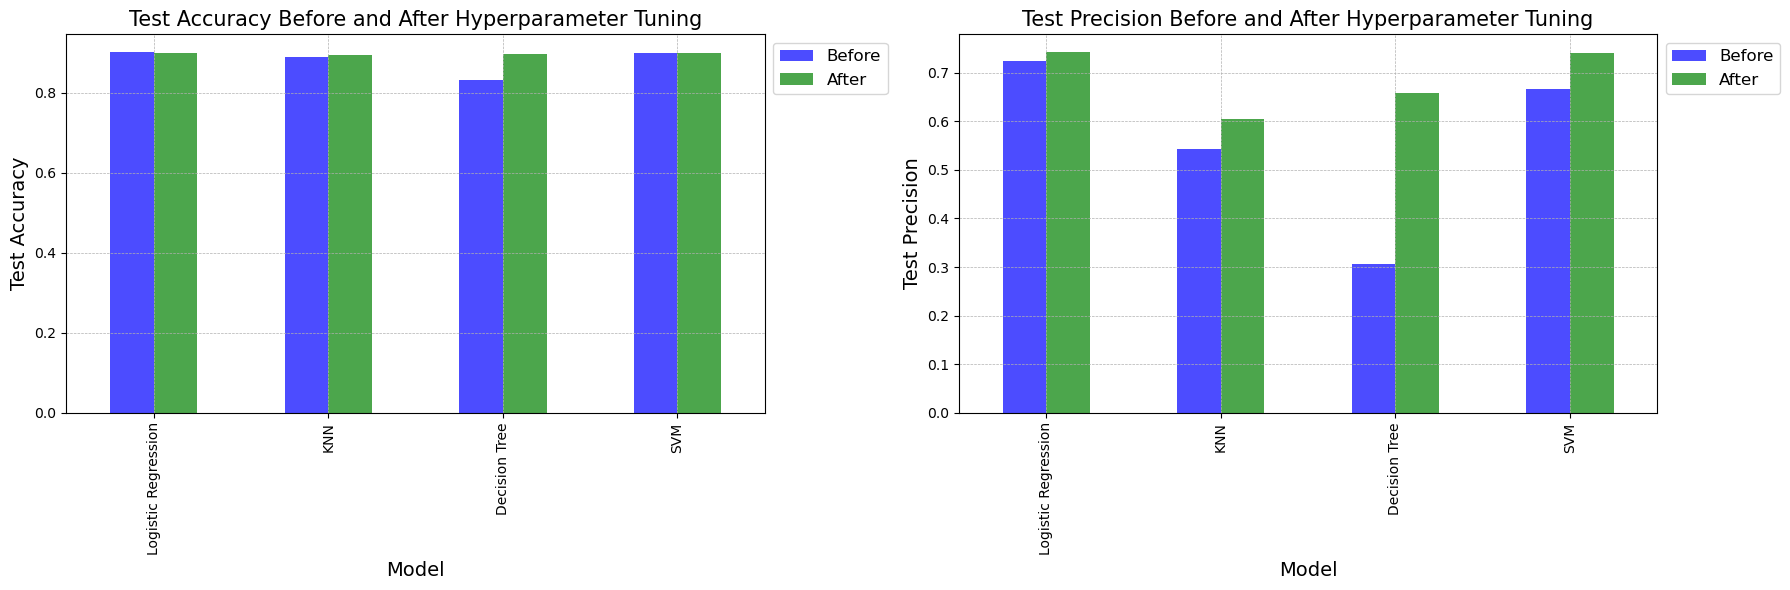

In [44]:
comparison_df = pd.merge(
    results_df[
        [
            "Model",
            "Train Accuracy",
            "Test Accuracy",
            "Train Precision",
            "Test Precision",
        ]
    ],
    final_results_df[
        [
            "Model",
            "Train Accuracy",
            "Test Accuracy",
            "Train Precision",
            "Test Precision",
        ]
    ],
    on="Model",
    suffixes=("_Before", "_After"),
)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
comparison_df.plot(
    x="Model",
    y=["Test Accuracy_Before", "Test Accuracy_After"],
    kind="bar",
    ax=axes[0],
    color=["blue", "green"],
    alpha=0.7,
)
axes[0].set_title("Test Accuracy Before and After Hyperparameter Tuning", fontsize=15)
axes[0].set_ylabel("Test Accuracy", fontsize=14)
axes[0].set_xlabel("Model", fontsize=14)
axes[0].legend(["Before", "After"], loc="best", bbox_to_anchor=(1, 1), fontsize=12)
axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)

comparison_df.plot(
    x="Model",
    y=["Test Precision_Before", "Test Precision_After"],
    kind="bar",
    ax=axes[1],
    color=["blue", "green"],
    alpha=0.7,
)
axes[1].set_title("Test Precision Before and After Hyperparameter Tuning", fontsize=15)
axes[1].set_ylabel("Test Precision", fontsize=14)
axes[1].set_xlabel("Model", fontsize=14)
axes[1].legend(["Before", "After"], loc="best", bbox_to_anchor=(1, 1), fontsize=12)
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig("model_performance_comparison.png")
plt.show()

Plotting ROC Curves: 100%|████████████████████████| 4/4 [02:34<00:00, 38.53s/it]


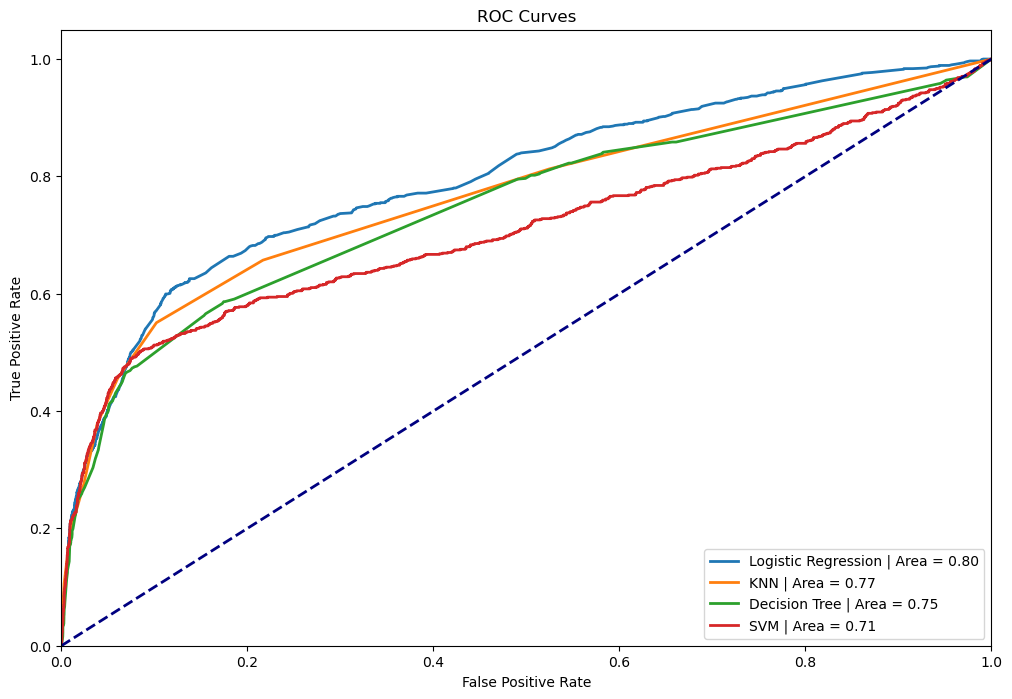

In [45]:
plt.figure(figsize=(12, 8))
for name, (model, param_grid) in tqdm(
    models_param_grids.items(),
    desc="Plotting ROC Curves",
    total=len(models_param_grids),
):
    best_params = grid_search_results_df.loc[
        grid_search_results_df["Model"] == name, "Best Parameters"
    ].values[0]
    model.set_params(**best_params)
    model.fit(X_train_processed_df, y_train)

    if isinstance(model, SVC):  # Ensure SVM has probability=True for predict_proba
        model.probability = True
        model.fit(X_train_processed_df, y_train)
    y_pred_prob = model.predict_proba(X_test_processed_df)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} | Area = {roc_auc:.2f}")

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.savefig("roc_curves.png")
plt.show()

Plotting Feature Importances:   0%|                       | 0/4 [00:00<?, ?it/s]

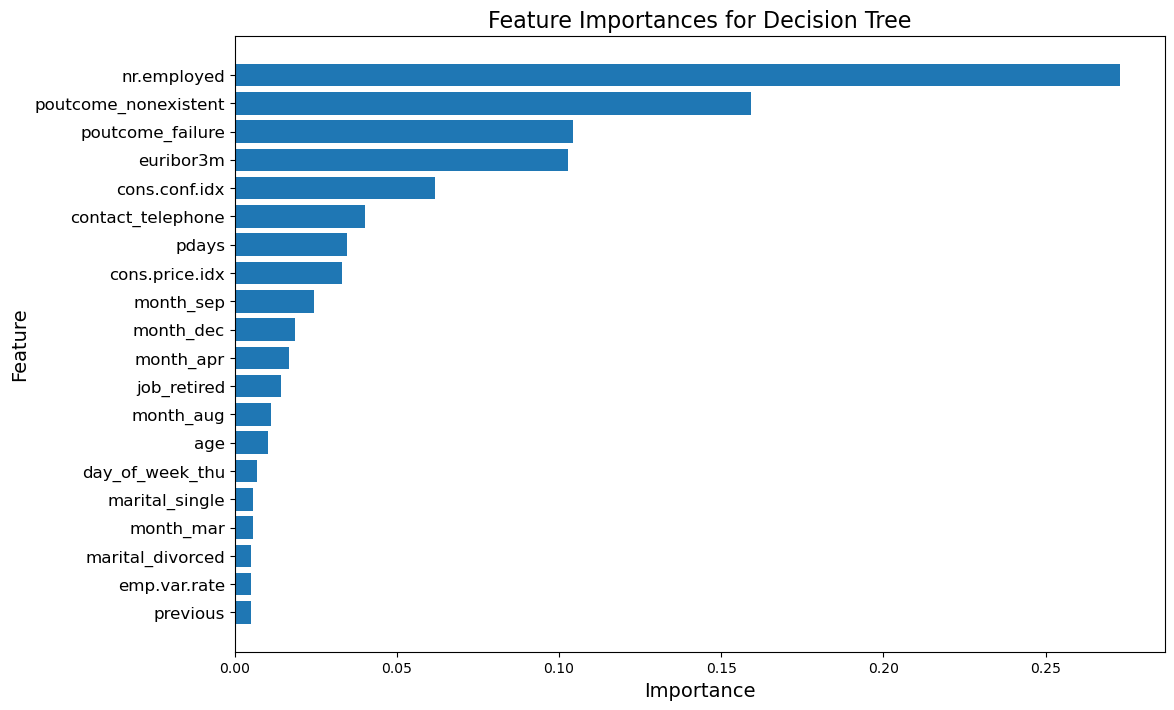

Plotting Feature Importances: 100%|███████████████| 4/4 [00:00<00:00, 10.01it/s]


In [46]:
for name, (model, param_grid) in tqdm(
    models_param_grids.items(),
    desc="Plotting Feature Importances",
    total=len(models_param_grids),
):
    if hasattr(model, "feature_importances_"):
        best_params = grid_search_results_df.loc[
            grid_search_results_df["Model"] == name, "Best Parameters"
        ].values[0]
        model.set_params(**best_params)
        model.fit(X_train_processed_df, y_train)
        importances = model.feature_importances_
        plt.figure(figsize=(12, 8))
        sorted_idx = np.argsort(importances)
        top_n = 20  # Show top 20 features
        sorted_idx = sorted_idx[-top_n:]
        plt.barh(range(len(sorted_idx)), importances[sorted_idx], align="center")
        plt.yticks(
            range(len(sorted_idx)),
            [all_feature_names[i] for i in sorted_idx],
            fontsize=12,
        )
        plt.xlabel("Importance", fontsize=14)
        plt.ylabel("Feature", fontsize=14)
        plt.title(f"Feature Importances for {name}", fontsize=16)
        plt.savefig(f"feature_importances_{name}.png")
        plt.show()

Plotting Confusion Matrices:   0%|                        | 0/4 [00:00<?, ?it/s]

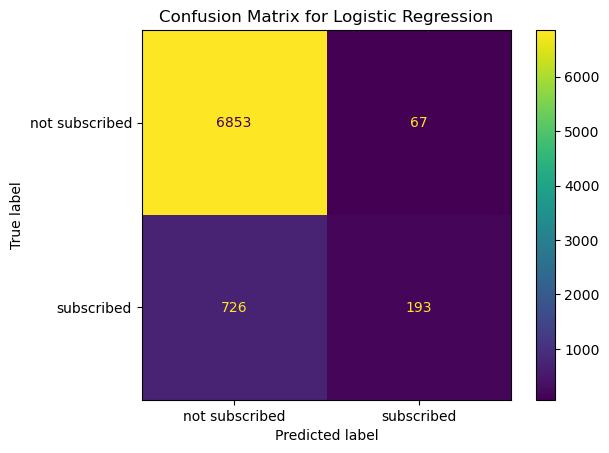

Plotting Confusion Matrices:  25%|████            | 1/4 [00:00<00:00,  3.26it/s]

[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.556 total time=   3.0s
[CV 3/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.714 total time=   0.7s
[CV 1/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.000 total time=   0.9s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.500 total time=   2.1s
[CV 3/5] END ..C=1, gamma=scale, kernel=sigmoid;, score=0.233 total time=   0.7s
[CV 2/5] END ....C=1, gamma=auto, kernel=linear;, score=0.500 total time=   2.1s
[CV 5/5] END ....C=1, gamma=auto, kernel=linear;, score=0.636 total time=   5.9s
[CV 5/5] END ..C=10, gamma=scale, kernel=linear;, score=0.636 total time=  23.4s
[CV 3/5] END .C=100, gamma=scale, kernel=linear;, score=0.514 total time=30.8min
[CV 5/5] END ..C=100, gamma=auto, kernel=linear;, score=0.636 total time=18.1min


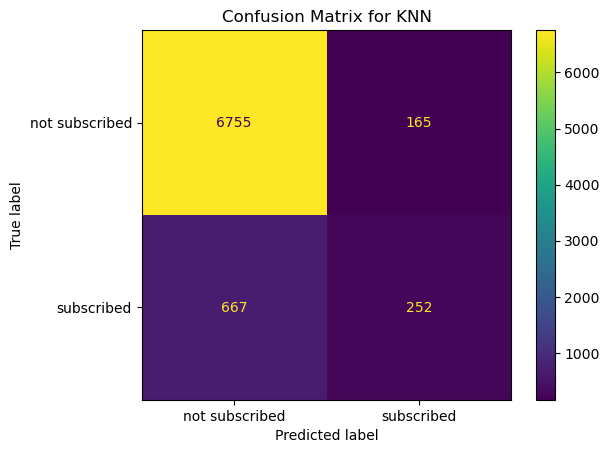

Plotting Confusion Matrices:  50%|████████        | 2/4 [00:00<00:00,  2.08it/s]

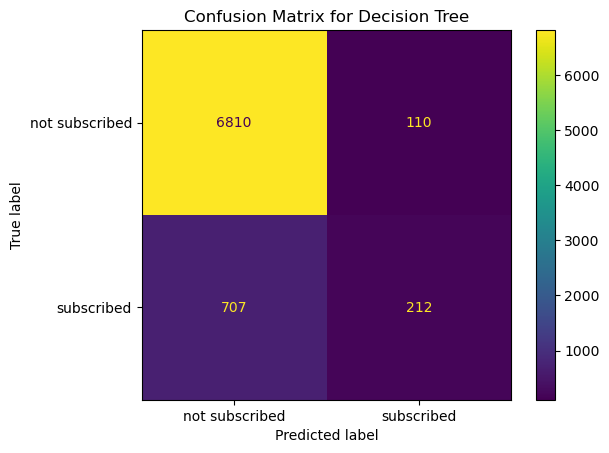

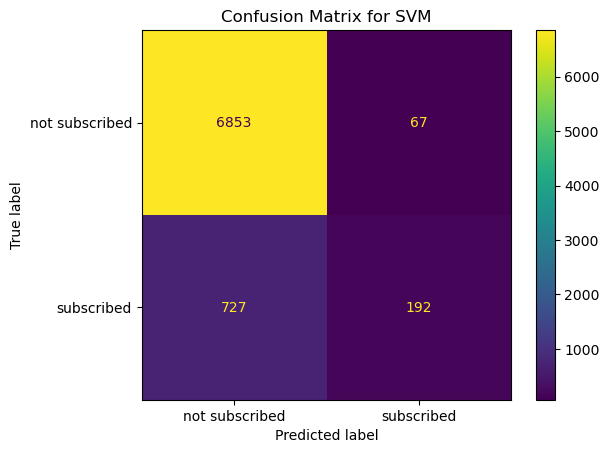

Plotting Confusion Matrices: 100%|████████████████| 4/4 [01:15<00:00, 18.80s/it]


In [48]:
# Plot confusion matrices for final models
for name, (model, param_grid) in tqdm(
    models_param_grids.items(),
    desc="Plotting Confusion Matrices",
    total=len(models_param_grids),
):
    best_params = grid_search_results_df.loc[
        grid_search_results_df["Model"] == name, "Best Parameters"
    ].values[0]
    model.set_params(**best_params)
    model.fit(X_train_processed_df, y_train)
    y_pred_test = model.predict(X_test_processed_df)
    cm = confusion_matrix(y_test, y_pred_test)
    cm_display = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["not subscribed", "subscribed"]
    )
    cm_display.plot()
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

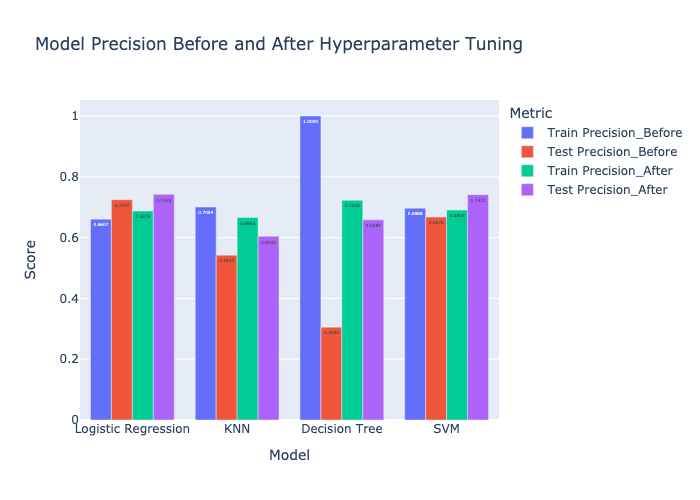

In [50]:
import plotly.express as px

fig = px.bar(
    comparison_df,
    x="Model",
    y=[
        "Train Precision_Before",
        "Test Precision_Before",
        "Train Precision_After",
        "Test Precision_After",
    ],
    barmode="group",
    title="Model Precision Before and After Hyperparameter Tuning",
    text_auto=".4f",
)
fig.update_traces(textfont_size=11, textangle=0, cliponaxis=False)
fig.update_yaxes(title_text="Score")
fig.update_layout(legend_title_text="Metric")
fig.show("png")

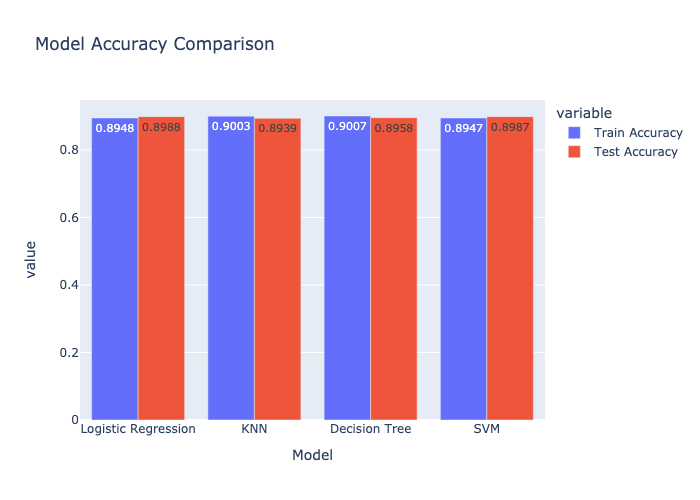

In [51]:
fig = px.bar(
    final_results_df,
    x="Model",
    y=["Train Accuracy", "Test Accuracy"],
    barmode="group",
    text_auto=".4f",
    title="Model Accuracy Comparison",
)
fig.update_traces(textfont_size=11, textangle=0, cliponaxis=False)
fig.show("png")

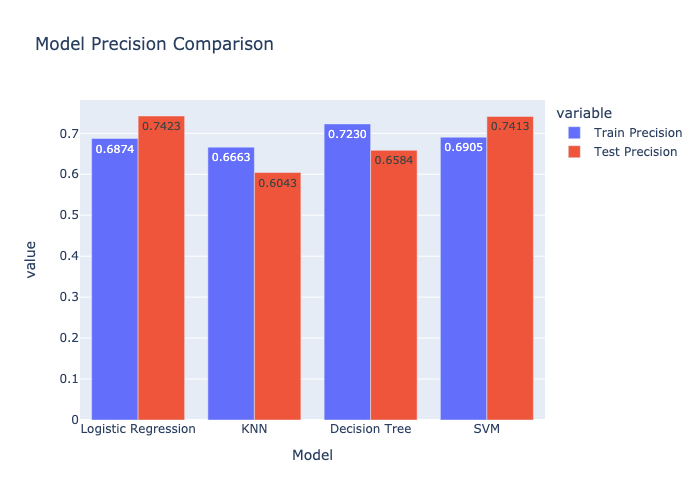

In [52]:
fig = px.bar(
    final_results_df,
    x="Model",
    y=["Train Precision", "Test Precision"],
    barmode="group",
    text_auto=".4f",
    title="Model Precision Comparison",
)
fig.update_traces(textfont_size=11, textangle=0, cliponaxis=False)
fig.show("png")

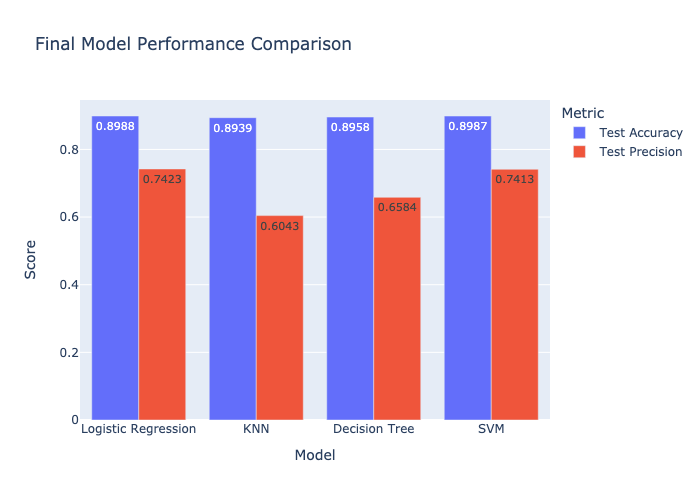

In [53]:
fig = px.bar(
    final_results_df,
    x="Model",
    y=["Test Accuracy", "Test Precision"],
    barmode="group",
    title="Final Model Performance Comparison",
    text_auto=".4f",
)
fig.update_traces(textfont_size=11, textangle=0, cliponaxis=False)
fig.update_yaxes(title_text="Score")
fig.update_layout(legend_title_text="Metric")
fig.show("png")

### Conclusion
We assessed four classification models on a Portuguese bank marketing campaign dataset to predict the success of marketing efforts. We optimized each model for best parameters and evaluated their performance based on train and test accuracy, precision, and computational time.

* KNN had the lowest performance among the models, indicating potential overfitting and lower precision.
* \[**Winner**\] SVM demonstrated the highest performance in terms of accuracy and precision but required significantly more computational time for training.
* Logistic Regression provided a good balance of performance and efficiency, demonstrating high accuracy and precision with a relatively quick training time.

##### Next Steps and Recommendations:
* Test using different numbers of features to see how it affects model performance.
* Continue tuning hyperparameters to optimize the models further.
* Test Random Forest or XGBoost models instead of Decision Tree since they are highly prone to overfitting and can potentially offer better performance.

This approach ensures data-driven decision-making, optimizing model performance, and considering practical constraints like computational time and overfitting tendencies.

##### Questions